# Run simulation studies for the normal cases

In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import time
from numpy.random import randn
from numpy.linalg import matrix_rank
from scipy.linalg import toeplitz, svdvals, norm, sqrtm
from scipy.io import loadmat

from iRRR.iRRR_normal import irrr_normal

from Sim_Normal_Setting import sim_normal_setting


In [2]:
ppth = '' # put directory here
choosesetting = 1 # choose from [1, 11:14, 2, 31:33, 41:44, 5]

settings = sim_normal_setting(choosesetting)

num = settings['num']
n = settings['n']
q = settings['q']
p = settings['p']
r = settings['r'] # per coef mat rank
missing = list(settings['missing']) # missing index for Y
X_tune = settings['X_tune']
cX_tune = settings['cX_tune']
X = settings['X']
cX = settings['cX']
Btrue = settings['Btrue']
Gammatrue = settings['Gammatrue']

# identity error covariance
SigmaE=np.eye(q)
SigmaEhf=np.eye(q)

# AR(1) error covariance matrix
SigmaE=toeplitz(0.5**(np.arange(q)))
SigmaEhf=sqrtm(SigmaE)


## Select Tuning Parameters
using tuning data
and just once, no repetition


In [3]:
# generate tuning set
E_tune=randn(n,q)@SigmaEhf
E_tune=np.subtract(E_tune,E_tune.mean(0))
Y_tune=cX_tune@Btrue+E_tune

# make response missing
Y_tune[missing]=np.nan

# candidate sets of tuning parameters
cand_iRRR_lam1=10**np.arange(-1.5,0.6,.1) # nuclear


## iRRR (theoretical $w_i$)
Note: gives a different answer every time because of the noise in E_tune (can set it to zero for debugging purposes)

iRRR converges after 4 iterations.
iRRR converges after 4 iterations.
iRRR converges after 5 iterations.
iRRR converges after 6 iterations.
iRRR converges after 8 iterations.
iRRR converges after 9 iterations.
iRRR converges after 10 iterations.
iRRR converges after 11 iterations.
iRRR converges after 13 iterations.
iRRR converges after 14 iterations.
iRRR converges after 15 iterations.
iRRR converges after 16 iterations.
iRRR converges after 17 iterations.
iRRR converges after 18 iterations.
iRRR converges after 19 iterations.
iRRR converges after 19 iterations.
iRRR converges after 20 iterations.
iRRR converges after 21 iterations.
iRRR converges after 21 iterations.
iRRR converges after 22 iterations.
iRRR converges after 23 iterations.


Text(0.5, 0, 'log10(iRRR lam1 range)')

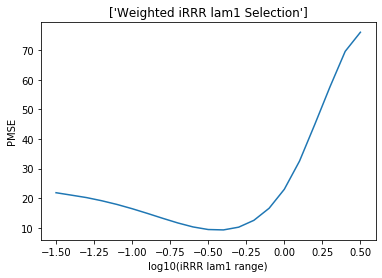

In [4]:
n2=len(cand_iRRR_lam1)

# weight
weight = [np.max(svdvals(x))*(np.sqrt(q)+np.sqrt(matrix_rank(x)))/x.shape[0]
          for x in X_tune]

iRRR_out=np.zeros(n2)
selrank=np.zeros(n2)
for j,lam1 in enumerate(cand_iRRR_lam1):
    [Bout,mu,Bcell_out,_,_]=irrr_normal(Y_tune,X_tune,lam1,
        {'varyrho':True,'Tol':0.01,'fig':False,'weight':weight})
    e = Btrue-Bout
    iRRR_out[j]=np.trace(e.T@Gammatrue@e)
    selrank[j]=matrix_rank(Bout)

ind2=np.argmin(iRRR_out);
lam1_wiRRR=cand_iRRR_lam1[ind2]
[np.min(cand_iRRR_lam1),lam1_wiRRR,np.max(cand_iRRR_lam1)]

# check if cand range covers the optimal
fig = plt.figure()
fig.clf()
ax = fig.add_subplot(111)
ax.plot(np.log10(cand_iRRR_lam1),iRRR_out)
ax.set_ylabel('PMSE')
ax.set_title(['Weighted iRRR lam1 Selection'])
ax.set_xlabel('log10(iRRR lam1 range)')


## Repeated simulation runs

In [5]:

# calc weight for iRRR
weight = [np.max(svdvals(x))*(np.sqrt(q)+np.sqrt(matrix_rank(x)))/n
          for x in X]

# multiple simulation run
nsim=100
rec_est=np.zeros((nsim))
rec_pred=np.zeros((nsim))
rec_rank=np.zeros((nsim))
rec_seprank=np.zeros((nsim,num))
rec_nuclear=np.zeros((nsim))
rec_time=np.zeros((nsim))

np.random.seed(13579)
for isim in range(nsim):
    print(f'Running Sim_{isim}')

    # simulate data in each simulation run
    E=randn(n,q)@SigmaEhf
    E=np.subtract(E,E.mean(0))
    Y=cX@Btrue+E
    Y[missing]=np.NaN;

    # implement diff methods
    # iRRR
    time1=time.time()
    [B_wiRRR,_,Bcell_wiRRR,_,_]=irrr_normal(Y,X,lam1_wiRRR,
        {'varyrho':True,'Tol':0.01,'fig':False,'weight':weight});
    T1=time.time() - time1


    # evaluate est
    e = (B_wiRRR-Btrue)
    rec_est[isim]=norm(e,ord='fro')
    rec_pred[isim]=np.trace(e.T@Gammatrue@e)
    rec_rank[isim]=matrix_rank(B_wiRRR)
    rec_seprank[isim,:] = [matrix_rank(Bk) for Bk in Bcell_wiRRR]
    rec_nuclear[isim]=sum(svdvals(B_wiRRR))
    rec_time[isim]=T1;

print(f'Mean PMSE: {rec_pred.mean()}')
print(f'Std PMSE: {rec_pred.std()}')
print(f'Mean time: {rec_time.mean()}')
print(f'Std time: {rec_time.std()}')


Running Sim_0
iRRR converges after 16 iterations.
Running Sim_1
iRRR converges after 16 iterations.
Running Sim_2
iRRR converges after 16 iterations.
Running Sim_3
iRRR converges after 16 iterations.
Running Sim_4
iRRR converges after 16 iterations.
Running Sim_5
iRRR converges after 16 iterations.
Running Sim_6
iRRR converges after 16 iterations.
Running Sim_7
iRRR converges after 16 iterations.
Running Sim_8
iRRR converges after 16 iterations.
Running Sim_9
iRRR converges after 16 iterations.
Running Sim_10
iRRR converges after 16 iterations.
Running Sim_11
iRRR converges after 16 iterations.
Running Sim_12
iRRR converges after 16 iterations.
Running Sim_13
iRRR converges after 16 iterations.
Running Sim_14
iRRR converges after 16 iterations.
Running Sim_15
iRRR converges after 16 iterations.
Running Sim_16
iRRR converges after 16 iterations.
Running Sim_17
iRRR converges after 16 iterations.
Running Sim_18
iRRR converges after 16 iterations.
Running Sim_19
iRRR converges after 16 it